In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6] # data di update per-10 menit, maka dari itu lompat 6 kali agar data menjadi per 60 menit (per jam)

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [5]:
print(df.shape)
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [7]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [8]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

In [9]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


In [10]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.955374,1.042725,-0.855026,-1.154613
294359,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.652949,1.254471,-0.855883,-1.154062
294365,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.306022,1.380734,-0.856739,-1.153511
294371,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,0.061765,1.412909,-0.857595,-1.152959


In [15]:
# Parameter windowing
input_width = 24
label_width = 24
shift = label_width
total_window_size = input_width + shift
OUT_STEPS = 24
# Definisikan irisan untuk input dan label
input_slice = slice(0, input_width)
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)

def make_windows(data, total_window_size, input_slice, labels_slice):
    x = []
    y = []
    for i in range(len(data) - total_window_size + 1):
        window = data[i:i+total_window_size]
        x.append(window[input_slice])
        y.append(window[labels_slice])
    return np.array(x), np.array(y)

# Membuat windowed dataset untuk set pelatihan, validasi, dan pengujian
x_train, y_train = make_windows(train_df.to_numpy(), total_window_size, input_slice, labels_slice)
x_val, y_val = make_windows(val_df.to_numpy(), total_window_size, input_slice, labels_slice)
x_test, y_test = make_windows(test_df.to_numpy(), total_window_size, input_slice, labels_slice)

# Verifikasi bentuk windowed dataset
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (49016, 24, 19)
y_train shape: (49016, 24, 19)
x_val shape: (13971, 24, 19)
y_val shape: (13971, 24, 19)
x_test shape: (6963, 24, 19)
y_test shape: (6963, 24, 19)


In [16]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window[0],window[1], epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False,  input_shape=(input_width, num_features)),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

train_scaled_final=(x_train, y_train)
history = compile_and_fit(multi_lstm_model, train_scaled_final)


Epoch 1/10
1532/1532 [==============================] - 9s 4ms/step - loss: 0.2903 - mean_absolute_error: 0.3613
Epoch 2/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2169 - mean_absolute_error: 0.2943
Epoch 3/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2089 - mean_absolute_error: 0.2850
Epoch 4/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2044 - mean_absolute_error: 0.2802
Epoch 5/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2016 - mean_absolute_error: 0.2773
Epoch 6/10
1532/1532 [==============================] - 7s 4ms/step - loss: 0.1995 - mean_absolute_error: 0.2754
Epoch 7/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.1979 - mean_absolute_error: 0.2741
Epoch 8/10
1532/1532 [==============================] - 6s 4ms/step - loss: 0.1962 - mean_absolute_error: 0.2728
Epoch 9/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.1949 - mean_absolu

In [42]:
y_train[:32,:,:]

array([[[ 1.28758078e+00, -1.56537088e+00, -1.65333844e+00, ...,
          1.36606880e+00, -3.65033783e-02,  1.42798311e+00],
        [ 1.23816811e+00, -1.54803976e+00, -1.63270747e+00, ...,
          1.22479437e+00, -3.54807035e-02,  1.42795529e+00],
        [ 1.20924361e+00, -1.56652629e+00, -1.64875378e+00, ...,
          1.00005921e+00, -3.44580492e-02,  1.42792675e+00],
        ...,
        [ 1.65516290e+00, -1.51684374e+00, -1.63156130e+00, ...,
          1.22479437e+00, -1.50322123e-02,  1.42724740e+00],
        [ 1.67083034e+00, -1.55843843e+00, -1.67396942e+00, ...,
          1.36606880e+00, -1.40100784e-02,  1.42720442e+00],
        [ 1.64672659e+00, -1.59656690e+00, -1.71064670e+00, ...,
          1.41425487e+00, -1.29879761e-02,  1.42716073e+00]],

       [[ 1.23816811e+00, -1.54803976e+00, -1.63270747e+00, ...,
          1.22479437e+00, -3.54807035e-02,  1.42795529e+00],
        [ 1.20924361e+00, -1.56652629e+00, -1.64875378e+00, ...,
          1.00005921e+00, -3.44580492e

[[[ 1.28758078 -1.56537088 -1.65333844 ...  1.3660688  -0.03650338
    1.42798311]
  [ 1.23816811 -1.54803976 -1.63270747 ...  1.22479437 -0.0354807
    1.42795529]
  [ 1.20924361 -1.56652629 -1.64875378 ...  1.00005921 -0.03445805
    1.42792675]
  ...
  [ 1.6551629  -1.51684374 -1.6315613  ...  1.22479437 -0.01503221
    1.4272474 ]
  [ 1.67083034 -1.55843843 -1.67396942 ...  1.3660688  -0.01401008
    1.42720442]
  [ 1.64672659 -1.5965669  -1.7106467  ...  1.41425487 -0.01298798
    1.42716073]]

 [[ 1.23816811 -1.54803976 -1.63270747 ...  1.22479437 -0.0354807
    1.42795529]
  [ 1.20924361 -1.56652629 -1.64875378 ...  1.00005921 -0.03445805
    1.42792675]
  [ 1.16465168 -1.58154659 -1.66021543 ...  0.70717864 -0.03343542
    1.42789749]
  ...
  [ 1.67083034 -1.55843843 -1.67396942 ...  1.3660688  -0.01401008
    1.42720442]
  [ 1.64672659 -1.5965669  -1.7106467  ...  1.41425487 -0.01298798
    1.42716073]
  [ 1.6551629  -1.66242517 -1.77597812 ...  1.3660688  -0.01196591
    1.42

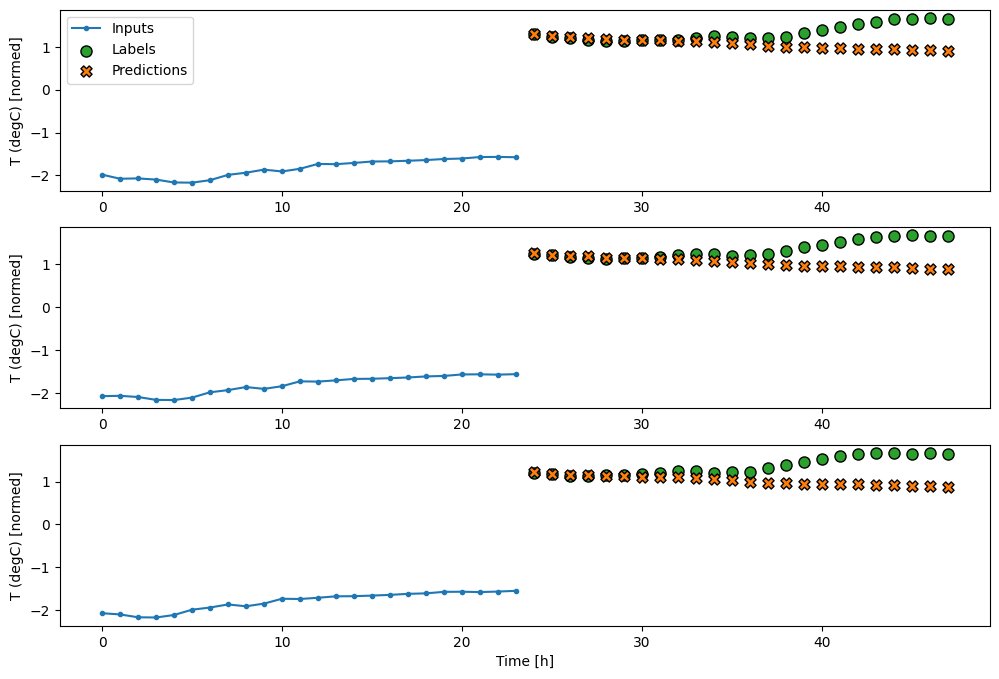

In [55]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot(inputs, labels, model=None, plot_col='T (degC)', max_subplots=3,
         input_indices=None, label_indices=None, column_indices=None, label_columns=None, label_columns_indices=None):
    
    # Set up the figure size for plotting
    plt.figure(figsize=(12, 8))
    # Find the index of the column to plot
    plot_col_index = column_indices[plot_col]
    # Determine the number of subplots to create, limited by max_subplots
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        # Create a subplot for each input example up to max_n
        plt.subplot(max_n, 1, n+1)
        # Set the label for the y-axis
        plt.ylabel(f'{plot_col} [normed]')
        # Plot the input data for the selected column
        plt.plot(input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        # Check if label_columns is specified, to find the corresponding label column index
        if label_columns:
            label_col_index = label_columns_indices.get(plot_col, None)
        else:
            # If not specified, use the same index as the input column
            label_col_index = plot_col_index

        # Skip plotting labels if the column index is not found
        if label_col_index is None:
            continue
        # Plot the labels data as scatter plot
        print(labels)
        print("plot_col_index: ", plot_col_index)
        print("n: ", n)
        if labels is not None:
            print(labels[n, :, label_col_index])
            plt.scatter(label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
        # If a model is provided, use it to make predictions and plot them
        if model is not None:
            predictions = model(inputs)
            plt.scatter(label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        # Add a legend to the first subplot only for clarity
        if n == 0:
            plt.legend()

    # Set the label for the x-axis
    plt.xlabel('Time [h]')
    plt.show()

# Contoh penggunaan fungsi plot
input_indices = np.arange(total_window_size)[input_slice]
label_indices = np.arange(total_window_size)[labels_slice]
label_columns = ['T (degC)']
if label_columns is not None:
    # Create a dictionary mapping label names to their indices in the dataframe
    label_columns_indices = {name: i for i, name in
                                enumerate(label_columns)}
# Create a dictionary mapping all column names to their indices in the dataframe
column_indices = {name: i for i, name in
                        enumerate(train_df.columns)}
plot(inputs=x_train[:,:,:], labels=y_train, model=multi_lstm_model, plot_col='T (degC)', 
     max_subplots=3, input_indices=input_indices, label_indices=label_indices, 
     column_indices=column_indices, label_columns=label_columns, label_columns_indices=label_columns_indices)
